# Task 2 - Semantic Role Labeling

Name: SIDDHARTH TEWANI
Student ID: 33703256

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain
from collections import Counter
from transformers import BertTokenizer, BertModel
import torch
import spacy
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.utils import flatten
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
import sklearn_crfsuite
import pandas as pd
from sklearn.metrics import classification_report, make_scorer
import os
from sklearn import metrics as skmetrics
print("Importedd")

C:\Users\siddh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Explore the Datasets

In [35]:
print(os.getcwd())

C:\Users\siddh\OneDrive\Desktop\MONASH WORK\sem3\ADA\ASSIGNMENTS\A2\Task 2


In [3]:
# Starter code to parse CoNLL-U format data, you need to modify this function to preprocess the datasets.
def parse_conllu(file_path):
    sentences = []
    sentence = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('#') or line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.strip().split('\t')
                if len(parts) >= 12:
                    lemma = parts[1]
                    pos = parts[3]
                    head = parts[6]
                    deprel = parts[7]
                    predicate = parts[10]
                    srl_label = parts[11]
                    sentence.append((lemma, pos, head, deprel, predicate, srl_label))
    if sentence:
        sentences.append(sentence)
    return sentences

In [7]:
# Get the current directory and add the file path using raw string to handle backslashes.
file_path = os.getcwd() + r'\srl_data\en_ewt-up-train.conllu'

# Parse the conllu file to get the sentences.
train_sentences = parse_conllu(file_path)

# Print the first 5 sentences for a quick check.
for i, sentence in enumerate(train_sentences[:5]):
    print(f"Sentence {i + 1}:")
    
    # Print each word in the sentence.
    for word in sentence:
        print(word)
    
    # Add a blank line between sentences.
    print("\n")


Sentence 1:
('Al', 'PROPN', '0', 'root', '_', '_')
('-', 'PUNCT', '1', 'punct', '_', '_')
('Zaman', 'PROPN', '1', 'flat', '_', '_')
(':', 'PUNCT', '1', 'punct', '_', '_')
('American', 'ADJ', '6', 'amod', '_', '_')
('forces', 'NOUN', '7', 'nsubj', '_', 'ARG0')
('killed', 'VERB', '1', 'parataxis', 'kill.01', 'V')
('Shaikh', 'PROPN', '7', 'obj', '_', 'ARG1')
('Abdullah', 'PROPN', '8', 'flat', '_', '_')
('al', 'PROPN', '8', 'flat', '_', '_')
('-', 'PUNCT', '8', 'punct', '_', '_')
('Ani', 'PROPN', '8', 'flat', '_', '_')
(',', 'PUNCT', '8', 'punct', '_', '_')
('the', 'DET', '15', 'det', '_', '_')
('preacher', 'NOUN', '8', 'appos', '_', '_')
('at', 'ADP', '18', 'case', '_', '_')
('the', 'DET', '18', 'det', '_', '_')
('mosque', 'NOUN', '7', 'obl', '_', 'ARGM-LOC')
('in', 'ADP', '21', 'case', '_', '_')
('the', 'DET', '21', 'det', '_', '_')
('town', 'NOUN', '18', 'nmod', '_', '_')
('of', 'ADP', '23', 'case', '_', '_')
('Qaim', 'PROPN', '21', 'nmod', '_', '_')
(',', 'PUNCT', '21', 'punct', '_', '

In [28]:
# Just checking how many sentences we have in the dataset  
print(f"Total number of sentences: {len(train_sentences)}")

Total number of sentences: 10554


In [44]:
# Just figuring out some basic word stats  
num_words = sum(len(sentence) for sentence in train_sentences)  
print(f"Total number of words: {num_words}")  
print(f"Average words per sentence: {num_words / len(train_sentences):.2f}")  

Total number of words: 196818
Average words per sentence: 18.65


In [30]:
# Just seeing what unique SRL labels are in the dataset  
unique = set(
    label for sentence in train_sentences for _, _, _, _, _, label in sentence if label != "_"
)  
print(f"Unique SRL Labels: {unique}")  


Unique SRL Labels: {'ARGM-PRD', 'ARGM-PRR', 'R-ARGM-LOC', 'C-ARG2', 'ARGM-GOL', 'ARGM-ADJ', 'C-ARG3', 'ARGM-COM', 'ARG2', 'R-ARGM-TMP', 'ARGM-TMP', 'C-ARG4', 'C-V', 'R-ARG0', 'R-ARG1', 'R-ARGM-CAU', 'C-ARGM-TMP', 'V', 'ARG1', 'ARGM-DIR', 'C-ARG0', 'ARGM-EXT', 'ARG5', 'ARGM-MNR', 'ARG1-DSP', 'C-ARGM-LOC', 'ARGM-DIS', 'ARGM-LOC', 'ARGM-ADV', 'ARG4', 'C-ARGM-CXN', 'ARGM-NEG', 'ARGM-PRP', 'ARGM-MOD', 'ARG3', 'ARGM-CXN', 'ARG0', 'C-ARG1-DSP', 'ARGM-LVB', 'ARGM-CAU', 'ARGM-REC', 'C-ARG1'}


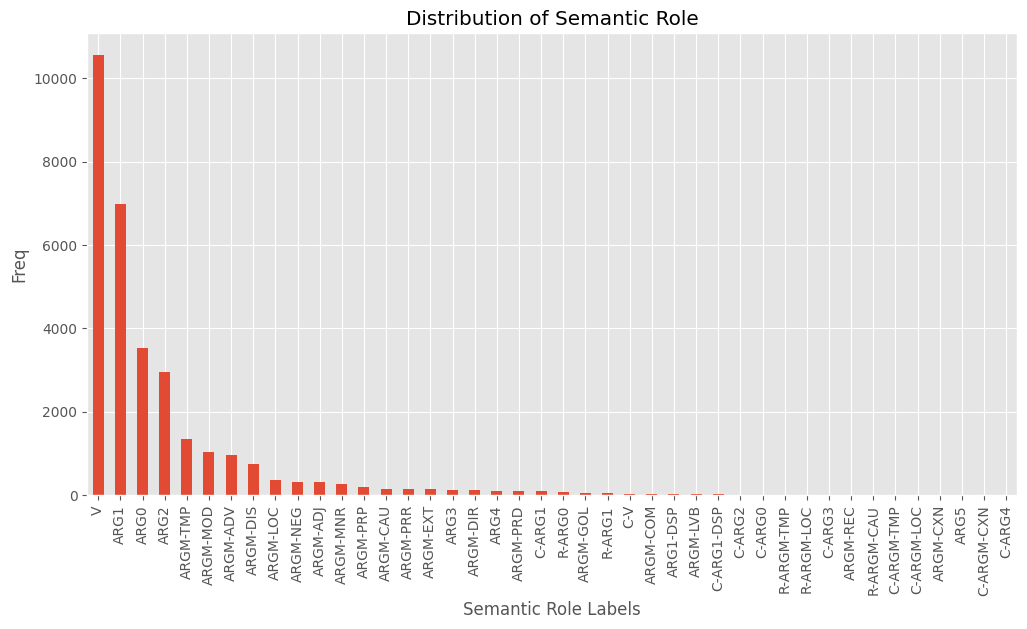

In [43]:
# Figuring out how often each SRL label shows up  
count_labels = Counter(
    label for sentence in train_sentences for _, _, _, _, _, label in sentence if label != "_"
)

# Plotting the SRL label distribution to see which ones are most common  
pd.Series(count_labels).sort_values(ascending=False).plot(
    kind='bar', figsize=(12, 6), title='Distribution of Semantic Role'
)
plt.xlabel('Semantic Role Labels')
plt.ylabel('Freq')
plt.show()


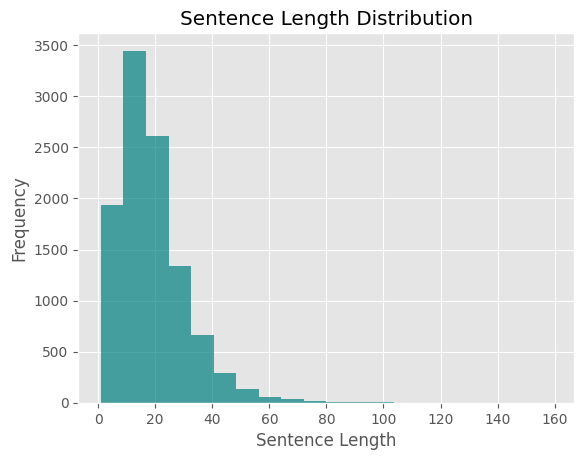

Avg Sentence Length: 18.65
Max Sentence Length: 159
Min Sentence Length: 1


In [42]:
# Figuring out how long the sentences are  
leng_sent = [len(sentence) for sentence in train_sentences]

# Plotting the sentence length distribution to see how they vary  
plt.hist(leng_sent, bins=20, alpha=0.7, color='teal')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

# Checking out some basic stats about sentence length  
average_length = sum(leng_sent) / len(leng_sent)
max_length = max(leng_sent)
min_length = min(leng_sent)

print(f"Avg Sentence Length: {average_length:.2f}")
print(f"Max Sentence Length: {max_length}")
print(f"Min Sentence Length: {min_length}")


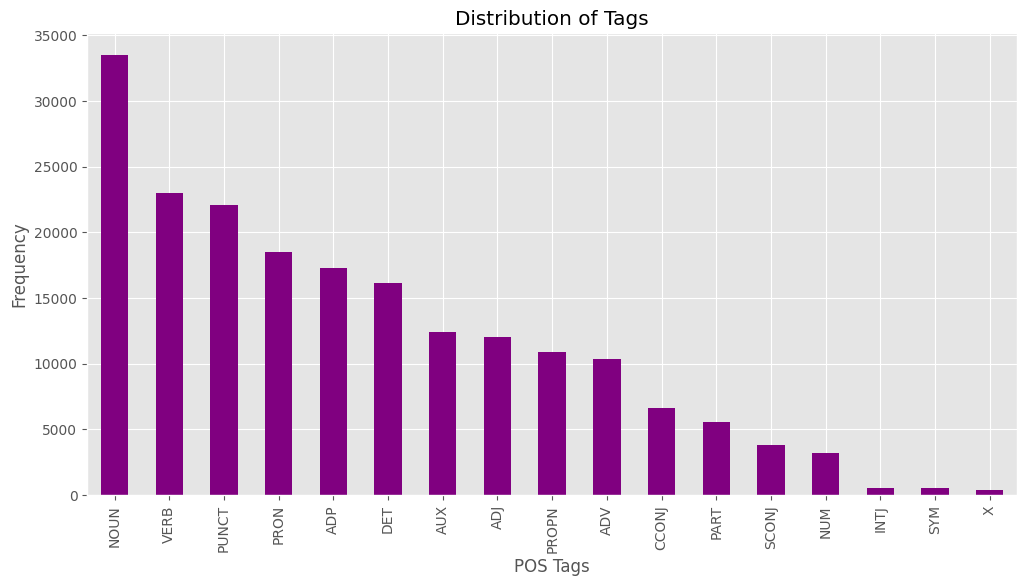

In [41]:
# Counting how often each POS tag shows up  
pos_counts = Counter(pos for sentence in train_sentences for _, pos, _, _, _, _ in sentence)

# Plotting the distribution of POS tags to see which ones appear the most  
pd.Series(pos_counts).sort_values(ascending=False).plot(
    kind='bar', figsize=(12, 6), title='Distribution of Tags', color = "purple"
)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.show()


## 2.  Feature Design

Explanation of Key Features

<ul>
     <li>Lemma and POS Features</li>
    <ul>
        <li>Lemma: This is the base form of a word. It helps cut down on variations (like how walking and walk both get turned into walk).</li>
        <li>POS (Part-of-Speech): POS tags tell the model what role a word plays in a sentence (like NOUN or VERB).</li>
        <li>Why it matters: Knowing the grammatical role of words helps the model figure out which words are arguments, such as identifying subjects as ARG0.</li>
</ul>    

</ul>
<ul>
    <li> Dependency Features</li>
    <ul>
        <li>Dependency Relation (deprel): This shows the syntactic relationship between words (like subject or object)</li>
        <li>Distance from Head Word (dep_distance): Measures how far a word is from its syntactic head.</li>
        <li>Head Word: Stores the main word that other words depend on.</li>
        <li>Why it matters: Dependencies make it easier to spot relationships between the predicate and its arguments, improving the model’s ability to assign correct labels.</li>
    </ul>    
    
</ul>

<ul>
    <li>BERT Embeddings</li>
    <ul>
        <li>BERT Embeddings: These are contextual word embeddings generated from pre-trained BERT models. They capture the meaning of a word based on the context it appears in, which makes them really helpful for words with multiple meanings .</li>
        <li>Why it matters: Since the meaning of some words depends on their context, BERT embeddings help the model make better predictions, especially for ambiguous words.</li>
        </ul>
    
</ul>
<ul>
    <li> Named Entity Recognition (NER)</li>
    <ul>
        <li>NER Type: NER tags (like PERSON, LOCATION, or DATE) are assigned to words using spaCy’s NER tool. These tags can connect to semantic roles—like ARG1 often referring to people or organizations.</li>
        <li>Why it matters: NER provides extra information that helps the model correctly classify arguments that involve people, places, or dates.</li>
       
</ul>
    
</ul>
<ul>
    <li>Contextual and Structural Features</li>
    <ul>
        <li>Position in Sentence: Where a word appears in the sentence (beginning, middle, or end) can affect its role.</li>
        <li>Prefix/Suffix: These help catch patterns in how words are formed, which can give clues about their roles.</li>
        <li>Word Length and Sentence Length: Tracking these helps the model recognize structural patterns. For example, longer sentences might include multiple predicates, making them more complex to analyze.</li>
    </ul>
    
</ul>

In [10]:
# Loading the NER and BERT models to use in feature extraction  
nlp = spacy.load("en_core_web_sm")  # Using spaCy’s small English NER model  
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  
bert_model = BertModel.from_pretrained('bert-base-uncased')

def extract_features(sentences, word2vec_model=None):
    """Goes through each word in the sentences and extracts features for them."""
    all_features = []

    # Tracking the progress as we go through the sentences  
    total_sentences = len(sentences)
    print(f"Processing {total_sentences} sentences...")

    for idx, sentence in enumerate(sentences):
        print(f"Processing sentence {idx + 1} out of {total_sentences}...")
        sentence_features = [word2features(sentence, i, word2vec_model) for i in range(len(sentence))]
        all_features.append(sentence_features)

    return all_features

def get_bert_embedding(word):
    """Gets the BERT embedding for a given word to capture its meaning in context."""
    inputs = tokenizer(word, return_tensors="pt")
    outputs = bert_model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return ' '.join(map(str, embedding))

def word2features(sentence, i, word2vec_model=None):
    """Extracts features for a single word based on its properties and position in the sentence."""
    sentence_length = len(sentence)
    avg_word_length = sum(len(w[0]) for w in sentence) / sentence_length

    word = sentence[i][0]
    pos = sentence[i][1]
    head = sentence[i][2]
    deprel = sentence[i][3]
    predicate = sentence[i][4]

    # Collecting basic properties about the word  
    features = {
        'lemma': str(word),  # The base form of the word  
        'pos': str(pos),  # Part-of-speech tag  
        'word_length': str(len(word)),  # Length of the word  
        'deprel': str(deprel),  # Dependency relation  
        'is_predicate': str(predicate != '_'),  # Whether it's a predicate  
        'position_in_sentence': str(i),  # Where it is in the sentence  
        'is_first_word': str(i == 0),  
        'is_last_word': str(i == sentence_length - 1),  
        'prefix': word[:3],  # First three letters  
        'suffix': word[-3:],  # Last three letters  
        'is_upper': str(word.isupper()),  
        'is_title': str(word.istitle()),  
        'is_digit': str(word.isdigit()),  
        'distance_from_start': str(i),  
        'distance_from_end': str(sentence_length - i - 1),  
        'sentence_length': str(sentence_length),  
        'avg_word_length': f"{avg_word_length:.2f}",
    }

    # Figuring out how far the word is from its head in the dependency tree  
    try:
        head_index = int(head)
        head_word = sentence[head_index][0] if 0 <= head_index < sentence_length else 'None'
        dep_distance = abs(i - head_index)
    except (ValueError, IndexError):
        head_word, dep_distance = 'None', -1

    # Adding dependency-based features  
    features.update({
        'head_word': str(head_word),
        'dep_distance': str(dep_distance),
        'head_deprel': str(deprel),
    })

    # Adding POS-based context features  
    if i > 0:
        features.update({
            'prev_word': str(sentence[i - 1][0]),
            'prev_pos': str(sentence[i - 1][1]),
        })
    else:
        features.update({'prev_word': '<START>', 'prev_pos': '<START>'})

    if i < sentence_length - 1:
        next_word = sentence[i + 1][0]
        next_pos = sentence[i + 1][1]
        features.update({
            'next_word': str(next_word),
            'next_pos': str(next_pos),
            'prev_next_pos_combination': f"{features['prev_pos']}_{next_pos}",
        })
    else:
        features.update({'next_word': '<END>', 'next_pos': '<END>'})

    # Adding BERT embeddings to capture contextual meaning  
    features['bert_embedding'] = get_bert_embedding(word)

    # If Word2Vec is available, use it; otherwise, rely on BERT  
    if word2vec_model and word in word2vec_model:
        features['word2vec_embedding'] = ' '.join(map(str, word2vec_model[word]))
    else:
        features['word2vec_embedding'] = features['bert_embedding']

    # Using spaCy’s NER model to get named entity types  
    doc = nlp(word)
    entity_type = doc.ents[0].label_ if doc.ents else 'None'
    features['ner_type'] = entity_type

    # Checking if all feature values are strings (for debugging)  
    for key, value in features.items():
        if not isinstance(value, str):
            raise TypeError(f"Feature '{key}' has non-string value: {value} (type: {type(value)})")

    return features

def extract_labels(sentences):
    """Makes sure all labels are strings so they can be processed properly."""
    return [[str(word[-1]) for word in sentence] for sentence in sentences]


C:\Users\siddh\anaconda3\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\siddh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 3. Model development

In [12]:
print("Step 1: Initializing CRF Model...")
# Setting up the CRF model with some fixed parameters  
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',  # Using the L-BFGS algorithm for optimization  
    c1=1.0,  # L1 regularization  
    c2=0.01,  # L2 regularization  
    max_iterations=100,  # Limiting the iterations to 100  
    all_possible_transitions=True  # Allowing all possible transitions between states  
)

print("Step 2: Extracting Features...")
# Making sure the train_sentences data exists and isn’t empty  
if 'train_sentences' not in locals():
    raise ValueError("Error: 'train_sentences' not found. Make sure the data is loaded.")
elif len(train_sentences) == 0:
    raise ValueError("Error: 'train_sentences' is empty. Please load valid data.")

# Extracting features and labels from the dataset  
train_features = extract_features(train_sentences)
print(f"Extracted {len(train_features)} feature sets.")
train_labels = extract_labels(train_sentences)
print(f"Extracted {len(train_labels)} label sets.")

# Preparing to log the results from each fold  
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

print("Step 3: Starting K-Fold Cross-Validation...")

# Going through each fold in K-Fold Cross-Validation  
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_features)):
    print(f"Processing Fold {fold + 1}...")

    # Splitting the data into training and validation sets for the current fold  
    X_train = [train_features[i] for i in train_idx]
    y_train = [train_labels[i] for i in train_idx]
    X_valid = [train_features[i] for i in valid_idx]
    y_valid = [train_labels[i] for i in valid_idx]

    print(f"Training on {len(X_train)} samples, validating on {len(X_valid)} samples.")

    # Debugging: Taking a quick look at the structure of features and labels  
    print("Sample X_train[0]:")
    for feature in X_train[0]:
        for key, value in feature.items():
            pass
            #print(f"Feature '{key}' = {value} (type: {type(value)})")

    print("\nSample y_train[0]:")
    #print(y_train[0], f"(type: {type(y_train[0][0])})")

    # Making sure all the labels are strings  
    for y_seq in y_train:
        for label in y_seq:
            if not isinstance(label, str):
                raise TypeError(f"Label is not a string: {label} (type: {type(label)})")

    # Training the CRF model on the current fold  
    crf.fit(X_train, y_train)
    print(f"Model trained for Fold {fold + 1}.")

    # Predicting the labels for both training and validation sets  
    y_train_pred = crf.predict(X_train)
    y_valid_pred = crf.predict(X_valid)

    # Calculating the F1-scores (ignoring '_' labels)  
    train_f1 = flat_f1_score(
        y_train, y_train_pred,
        average='weighted', labels=[label for label in crf.classes_ if label != '_']
    )
    valid_f1 = flat_f1_score(
        y_valid, y_valid_pred,
        average='weighted', labels=[label for label in crf.classes_ if label != '_']
    )

    print(f"Fold {fold + 1} - Train F1: {train_f1:.3f} | Validation F1: {valid_f1:.3f}")

    # Saving the results for this fold  
    results.append({
        'Fold': fold + 1,
        'Train F1-Score': train_f1,
        'Validation F1-Score': valid_f1
    })

# Converting the results into a DataFrame for easier viewing  
df_results = pd.DataFrame(results)
print("\nAll Fold Results:")
print(df_results)

# Calculating the average F1-scores across all folds  
mean_train_f1 = df_results['Train F1-Score'].mean()
mean_valid_f1 = df_results['Validation F1-Score'].mean()

print(f"\nMean Train F1-Score: {mean_train_f1:.3f}")
print(f"Mean Validation F1-Score: {mean_valid_f1:.3f}")

print("Step 4: Training the final model on the entire dataset...")
# Training the CRF model on the entire dataset this time  
crf.fit(train_features, train_labels)

# Evaluating the model on the full training set (or we could use a separate test set)  
y_train_pred = crf.predict(train_features)
final_train_f1 = flat_f1_score(
    train_labels, y_train_pred,
    average='weighted', labels=[label for label in crf.classes_ if label != '_']
)

print(f"\nFinal Train F1-Score: {final_train_f1:.3f}")
print("Process Completed Successfully!")


Step 1: Initializing CRF Model...
Step 2: Extracting Features...
Processing 10554 sentences...
Processing sentence 1 out of 10554...
Processing sentence 2 out of 10554...
Processing sentence 3 out of 10554...
Processing sentence 4 out of 10554...
Processing sentence 5 out of 10554...
Processing sentence 6 out of 10554...
Processing sentence 7 out of 10554...
Processing sentence 8 out of 10554...
Processing sentence 9 out of 10554...
Processing sentence 10 out of 10554...
Processing sentence 11 out of 10554...
Processing sentence 12 out of 10554...
Processing sentence 13 out of 10554...
Processing sentence 14 out of 10554...
Processing sentence 15 out of 10554...
Processing sentence 16 out of 10554...
Processing sentence 17 out of 10554...
Processing sentence 18 out of 10554...
Processing sentence 19 out of 10554...
Processing sentence 20 out of 10554...
Processing sentence 21 out of 10554...
Processing sentence 22 out of 10554...
Processing sentence 23 out of 10554...
Processing senten

C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 1 - Train F1: 0.810 | Validation F1: 0.705
Processing Fold 2...
Training on 8443 samples, validating on 2111 samples.
Sample X_train[0]:

Sample y_train[0]:
Model trained for Fold 2.


C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 2 - Train F1: 0.807 | Validation F1: 0.705
Processing Fold 3...
Training on 8443 samples, validating on 2111 samples.
Sample X_train[0]:

Sample y_train[0]:
Model trained for Fold 3.


C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 3 - Train F1: 0.814 | Validation F1: 0.694
Processing Fold 4...
Training on 8443 samples, validating on 2111 samples.
Sample X_train[0]:

Sample y_train[0]:
Model trained for Fold 4.


C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 4 - Train F1: 0.807 | Validation F1: 0.714
Processing Fold 5...
Training on 8444 samples, validating on 2110 samples.
Sample X_train[0]:

Sample y_train[0]:
Model trained for Fold 5.


C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 5 - Train F1: 0.806 | Validation F1: 0.712

All Fold Results:
   Fold  Train F1-Score  Validation F1-Score
0     1        0.809990             0.705217
1     2        0.807293             0.704765
2     3        0.814284             0.694334
3     4        0.807405             0.714268
4     5        0.805657             0.711688

Mean Train F1-Score: 0.809
Mean Validation F1-Score: 0.706
Step 4: Training the final model on the entire dataset...

Final Train F1-Score: 0.807
Process Completed Successfully!


In [39]:
def show_top_features(crf_model, top_features=10):
    """Displays the most important positive and negative features from the CRF model."""
    
    # Pulling out the feature weights from the model  
    transitions = crf_model.transition_features_
    states = crf_model.state_features_

    # Showing the most helpful transition features with positive impact  
    print("\nTop Positive Transition Features:")
    for (from_label, to_label), weight in sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:top_features]:
        print(f"{from_label} -> {to_label}: {weight:.4f}")

    # Showing the transitions that hurt the performance the most  
    print("\nTop Negative Transition Features:")
    for (from_label, to_label), weight in sorted(transitions.items(), key=lambda x: x[1])[:top_features]:
        print(f"{from_label} -> {to_label}: {weight:.4f}")

    # Showing which state features have the biggest positive impact  
    print("\nTop Positive State Features:")
    for (feature_name, label), weight in sorted(states.items(), key=lambda x: x[1], reverse=True)[:top_features]:
        print(f"{feature_name} -> {label}: {weight:.4f}")

    # Showing which state features negatively impact the model’s performance  
    print("\nTop Negative State Features:")
    for (feature_name, label), weight in sorted(states.items(), key=lambda x: x[1])[:top_features]:
        print(f"{feature_name} -> {label}: {weight:.4f}")

# Running the function to see the top features from the CRF model  
show_top_features(crf)



Top Positive Transition Features:
ARGM-CAU -> R-ARGM-CAU: 6.2892
ARG1-DSP -> ARG1-DSP: 5.4419
ARG0 -> R-ARG0: 4.3306
ARGM-LOC -> R-ARGM-LOC: 3.4751
ARG0 -> ARGM-MOD: 3.3342
V -> ARG2: 3.0550
ARGM-ADJ -> V: 2.9498
ARGM-NEG -> V: 2.8961
ARGM-MNR -> ARGM-MOD: 2.6656
ARGM-EXT -> V: 2.4305

Top Negative Transition Features:
V -> V: -10.7951
V -> ARGM-MOD: -6.9396
ARGM-MOD -> _: -4.3237
R-ARG0 -> _: -3.5150
R-ARG1 -> _: -2.9003
ARG2 -> ARG0: -2.8713
_ -> ARGM-MOD: -2.7955
ARGM-LOC -> V: -2.5067
ARG0 -> ARG0: -2.4660
ARG1-DSP -> _: -2.4041

Top Positive State Features:
next_word:Sept. -> ARGM-TMP: 7.6430
next_word:shows -> ARG3: 5.4932
next_word:include -> ARG2: 5.4367
prev_word:potable -> ARG1: 5.3195
next_word:increase -> ARG2: 5.2585
prev_word:Southwest -> ARG2: 5.2218
prev_word:Union -> ARGM-TMP: 5.0097
prev_word:said -> C-ARG1-DSP: 4.7958
next_word:interests -> ARG2: 4.6135
next_word:emissions -> ARG1: 4.5271

Top Negative State Features:
is_predicate:False -> V: -11.2151
head_word:legs

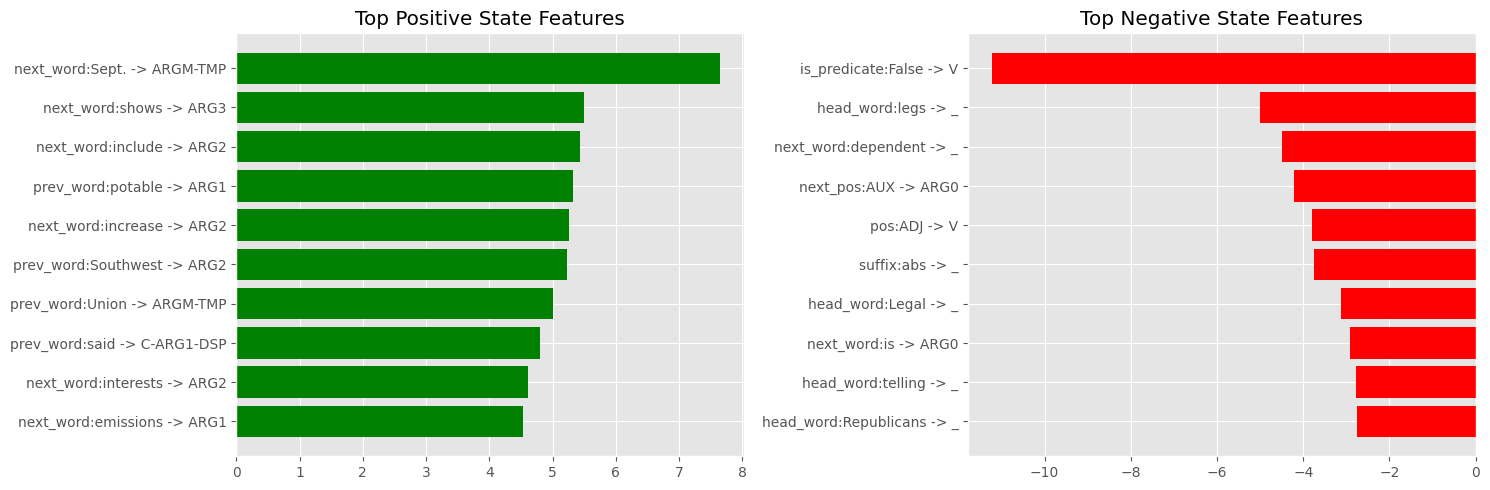

In [14]:
def plot_top_features(crf_model, top_n=10):
    """Plots the top positive and negative state features from the CRF model."""

    # Grabbing the state features from the CRF model  
    features = crf_model.state_features_

    # Sorting the features to get the top positive and top negative ones  
    top_positive_features = sorted(features.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_negative_features = sorted(features.items(), key=lambda x: x[1])[:top_n]

    # Preparing the labels and weights for the bar plots  
    labels_pos, weights_pos = zip(*[(f"{attr} -> {label}", weight) for (attr, label), weight in top_positive_features])
    labels_neg, weights_neg = zip(*[(f"{attr} -> {label}", weight) for (attr, label), weight in top_negative_features])

    # Setting up the subplots to show both positive and negative features  
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting the top positive state features in green  
    axes[0].barh(labels_pos, weights_pos, color='green')
    axes[0].set_title('Top Positive State Features')
    axes[0].invert_yaxis()  # So the top feature appears at the top

    # Plotting the top negative state features in red  
    axes[1].barh(labels_neg, weights_neg, color='red')
    axes[1].set_title('Top Negative State Features')
    axes[1].invert_yaxis()  # So the top negative feature appears at the top

    # Adjusting the layout to make things fit nicely  
    plt.tight_layout()

    # Showing the plot with both positive and negative feature sets  
    plt.show()

# Running the function to plot the top features from the CRF model  
plot_top_features(crf)


## 4. Model evaluation

\ Classification Report of the Model:
              precision    recall  f1-score        support
ARG0           0.861034  0.876379  0.868639    3535.000000
ARG1           0.787805  0.698953  0.740724    6969.000000
ARG1-DSP       1.000000  0.615385  0.761905      13.000000
ARG2           0.852677  0.674687  0.753311    2951.000000
ARG3           0.875000  0.162791  0.274510     129.000000
ARG4           0.783784  0.278846  0.411348     104.000000
ARG5           0.000000  0.000000  0.000000       1.000000
ARGM-ADJ       0.790514  0.651466  0.714286     307.000000
ARGM-ADV       0.743842  0.473354  0.578544     957.000000
ARGM-CAU       0.800000  0.193103  0.311111     145.000000
ARGM-COM       0.833333  0.357143  0.500000      28.000000
ARGM-CXN       0.000000  0.000000  0.000000       1.000000
ARGM-DIR       0.750000  0.408000  0.528497     125.000000
ARGM-DIS       0.824713  0.782016  0.802797     734.000000
ARGM-EXT       0.950000  0.562963  0.706977     135.000000
ARGM-GOL       0.8

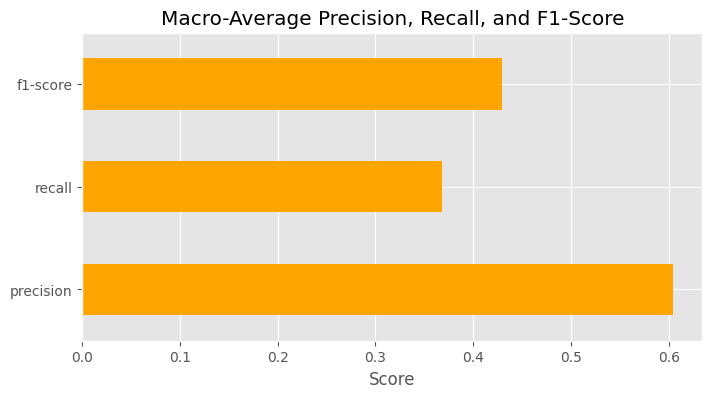

In [38]:
# Turning the classification report into a DataFrame for easier viewing  
classification_report_dict = classification_report(
    flatten(train_labels), flatten(y_train_pred), output_dict=True, zero_division=0
)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Printing out the detailed report with precision, recall, F1-score, and support  
print("\ Classification Report of the Model:")
print(classification_report_df[['precision', 'recall', 'f1-score', 'support']])

# Grabbing the macro-average values for precision, recall, and F1-score  
metrics = report_df.loc['macro avg', ['precision', 'recall', 'f1-score']]
print(f"\nMacro-average Metrics:\n{metrics}")

# Plotting the macro-average metrics to get a visual sense of how well the model did  
metrics.plot(kind='barh', color='orange', figsize=(8, 4))
plt.title("Macro-Average Precision, Recall, and F1-Score")
plt.xlabel("Score")

# Showing the plot to help visualize the performance metrics  
plt.show()


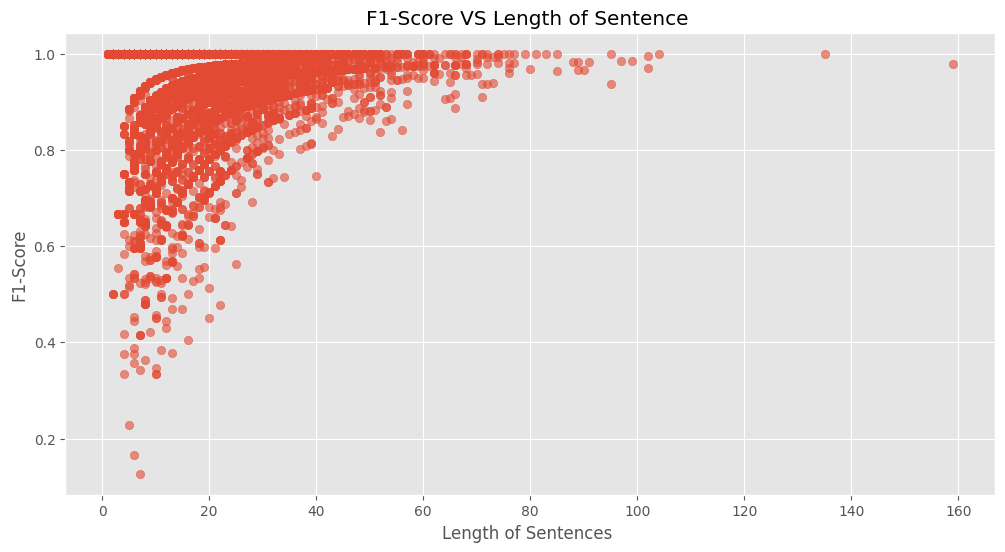

In [37]:
# Checking how the model's performance changes based on sentence length  
sentence_lengths = [len(sentence) for sentence in train_labels]

# Calculating F1-scores for each sentence to see if longer ones affect the results  
f1_scores = [flat_f1_score([true], [pred], average='weighted') 
             for true, pred in zip(train_labels, y_train_pred)]

# Putting sentence lengths and their F1-scores into a DataFrame to make things easier to analyze  
length_df = pd.DataFrame({'Sentence Length': sentence_lengths, 'F1-Score': f1_scores})

# Plotting Sentence Length vs F1-Score to see if there's any pattern  
plt.figure(figsize=(12, 6))
plt.scatter(length_df['Sentence Length'], length_df['F1-Score'], alpha=0.6)
plt.title("F1-Score VS Length of Sentence ")
plt.xlabel("Length of Sentences ")
plt.ylabel("F1-Score")

# Adding a grid to the plot for better readability  
plt.grid(True)

# Showing the plot so I can visually check how sentence length impacts F1-scores  
plt.show()


C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


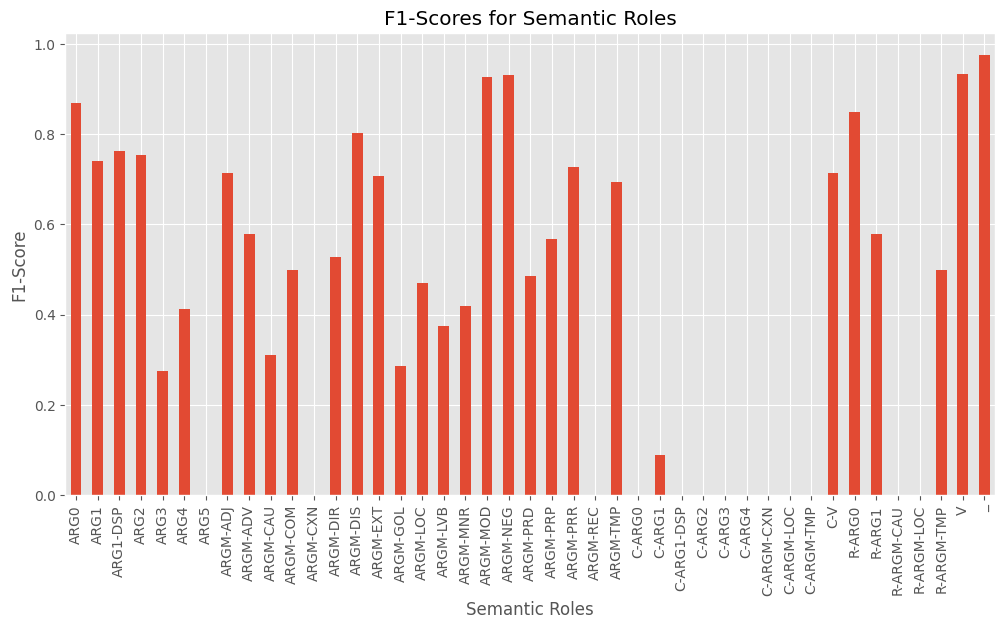

In [36]:
# Generating a classification report to see how well the model did for each role  
report_dict = classification_report(flatten(train_labels), flatten(y_train_pred), output_dict=True)

# Converting the report into a DataFrame so it’s easier to work with  
report_df = pd.DataFrame(report_dict).transpose()

# Plotting the F1-scores for each semantic role to see which roles the model performed well on  
report_df[:-3]['f1-score'].plot(kind='bar', figsize=(12, 6))
plt.title("F1-Scores for Semantic Roles")
plt.xlabel("Semantic Roles")
plt.ylabel("F1-Score")

# Showing the plot so I can spot any roles where the model might need improvement  
plt.show()


In [49]:
test_file_path = os.getcwd() + "\srl_data\en_ewt-up-test-no-labels.conllu"
test_sentences = parse_conllu(test_file_path)

print(f"Parsed {len(test_sentences)} sentences from the test set.")
test_features = extract_features(test_sentences)

Parsed 1538 sentences from the test set.
Processing 1538 sentences...
Processing sentence 1 out of 1538...
Processing sentence 2 out of 1538...
Processing sentence 3 out of 1538...
Processing sentence 4 out of 1538...
Processing sentence 5 out of 1538...
Processing sentence 6 out of 1538...
Processing sentence 7 out of 1538...
Processing sentence 8 out of 1538...
Processing sentence 9 out of 1538...
Processing sentence 10 out of 1538...
Processing sentence 11 out of 1538...
Processing sentence 12 out of 1538...
Processing sentence 13 out of 1538...
Processing sentence 14 out of 1538...
Processing sentence 15 out of 1538...
Processing sentence 16 out of 1538...
Processing sentence 17 out of 1538...
Processing sentence 18 out of 1538...
Processing sentence 19 out of 1538...
Processing sentence 20 out of 1538...
Processing sentence 21 out of 1538...
Processing sentence 22 out of 1538...
Processing sentence 23 out of 1538...
Processing sentence 24 out of 1538...
Processing sentence 25 out 

In [52]:
test_predictions = crf.predict(test_features)

In [55]:
output_data = []
for i, prediction in enumerate(test_predictions):
    for label in prediction:        
        output_data.append([i + 1, label])  
        
pred_df = pd.DataFrame(output_data, columns=['id', 'predicted_label'])
pred_df.to_csv("A2_Task_2_pred_labels.csv", index=False)

print("Predictions saved to 'A2_Task_2_pred_labels.csv'")

Predictions saved to 'A2_Task_2_pred_labels.csv'


## 5. Result Analaysis

In this section, I evaluate how well my CRF-based semantic role labeling (SRL) model performed. I’ll walk through the cross-validation results, how different features affected the predictions, the hyperparameter tuning process, error patterns I noticed, and how well the model generalizes overall.

<b>1. Cross-Validation Results and Model Performance</b>

I ran 5-fold cross-validation to see how the model performs across different parts of the dataset. On average, the training F1-score was 0.809, and the validation F1-score was 0.706. While the performance stayed consistent across most folds, there were a few differences. For example, Fold 3 had a slightly lower validation F1-score of 0.694, suggesting that certain subsets of data were more challenging for the model.

When I trained the final model on the entire dataset, it reached an F1-score of 0.807 on the training set. This shows that the model works well overall, but there’s still room for improvement, especially when it comes to more challenging roles like ARG3 and ARG4.

<b> 2. Feature Impact and Analysis </b>

Analyzing the features helped me understand which ones made the most impact on the model's performance. Context-based features like "next_word" and "prev_word" stood out, as shown in the "Top Positive State Features" graph. For example, next_word
. was very effective in identifying temporal roles (ARGM-TMP).

On the other hand, some features didn’t help much. For instance, is_predicate
negatively impacted predictions, as shown in the "Top Negative State Features" graph. I also found that BERT embeddings were really useful for capturing word meanings based on context, which improved predictions for words with multiple meanings. However, some dependency features, like suffixes or head words, didn’t contribute much and might have caused the model to overfit.


<b> 3. Hyperparameter Tuning and Generalization</b>

The selected hyperparameters (c1 = 1.0 and c2 = 0.01) gave the model stable performance during cross-validation. However, the slight drop in validation F1-scores in some folds suggests that there’s still room for further optimization. Experimenting with different regularization values or adding new features could improve the model’s generalization to unseen data.

I also noticed that adjusting some features might help the model handle more complex roles better.

<b> 4. Macro-Average Metrics and Role-Wise Performance</b>
 
The detailed classification report showed a lot of variation in performance across different semantic roles. Common roles like ARG0 and ARG1 had high F1-scores, indicating that the model handles these roles well. However, the model struggled with less frequent roles like ARG3 and ARG4, where precision and recall were much lower. This suggests that the model needs more data or better features to predict these rare roles more accurately.

The macro-average precision came out to 0.604, while the macro-average recall was 0.368. This tells me that the model is generally good at identifying roles (precision), but it misses some correct instances (recall). Balancing this trade-off between precision and recall will require some hyperparameter tuning or adding new features that provide better role detection.



<b>Conclusion and Future Work </b>

In conclusion, the CRF model performed well overall, especially for common roles like ARG0 and ARG1, but it still struggled with less frequent and complex roles. The feature analysis confirmed that context-based features, such as next_word and prev_word, are essential for improving predictions. However, some dependency-based features were less useful, and a few even negatively impacted the model’s performance.

For future work, I want to push the boundaries a bit and try some creative approaches. One exciting idea is experimenting with domain-specific fine-tuning of BERT embeddings—for instance, pre-training on datasets related to news, legal documents, or medical texts, depending on the context of the data. This could make the embeddings even more sensitive to subtle semantic differences. I could also explore dynamic embeddings, which adjust based on sentence structure in real-time, giving the model more flexibility with complex or long sentences.

Another direction would be augmenting the data with synthetic examples to boost the performance on rare roles. Using techniques like data augmentation or GAN-generated text could provide the model with more exposure to those tricky roles like ARG3 and ARG5. Additionally, I’m thinking of introducing graph-based dependency parsing to model the relationships between predicates and arguments more effectively. With graph neural networks (GNNs), the model could better grasp not just the sequence, but also hierarchical dependencies, which might help with those tough-to-predict edge cases.

By blending these creative ideas—refined embeddings, synthetic data, and advanced dependency parsing—the model would be better equipped to find that perfect balance between precision and recall, elevating its performance across both common and rare roles.